In [1]:
import subprocess
import ltspice
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def gen_noise(duration = 200e-3, sampling_rate = 10e6, noise_bw = 80e3, mean = 0.0, std_dev = 1):
    num_samples = int(duration * noise_bw)
    # Generate time array
    time = np.linspace(0, duration, num_samples)
    # Generate white Gaussian noise
    noise = np.random.normal(mean, std_dev, num_samples)
    # Zero-hold the data to match the sampling rate
    hold_factor = int(sampling_rate / noise_bw)
    held_time = np.linspace(0, duration, int(duration*sampling_rate))
    held_noise = np.repeat(noise, hold_factor)
    # Combine time and noise into a single array
    data = np.column_stack((held_time, held_noise))
    return data

In [3]:
def gen_TRAG_pulse(duration = 200e-3, sampling_rate = 10e3,Vreset = -1,treset = 50e-3,Vpulse = 0.2,tpulse = 80e-3):
    num_samples = int(duration * sampling_rate)
    # Generate time array
    time = np.linspace(0, duration, num_samples)
    V_trag = np.ones(num_samples)*Vreset
    V_trag[0:int(treset*sampling_rate)] = Vreset
    V_trag[int(treset*sampling_rate):int((treset+tpulse)*sampling_rate)] = Vpulse
    data = np.column_stack((time, V_trag))
    return data

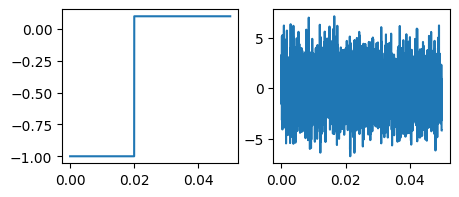

In [58]:
kramers_pulse = gen_TRAG_pulse(duration = 50e-3, sampling_rate = 1e6,Vreset = -1,treset = 20e-3,Vpulse = 0.1,tpulse = 30e-3)
noisedata  = gen_noise(duration = 50e-3, sampling_rate = 1e6, noise_bw = 100e3, mean = 0.0, std_dev = 2)

plt.figure(figsize=(5,2))
plt.subplot(1,2,1); plt.plot(kramers_pulse[:,0],kramers_pulse[:,1])
plt.subplot(1,2,2); plt.plot(noisedata[:,0],noisedata[:,1])


In [59]:
# Path to LTSpice executable
ltspice_exe = 'C:\\Users\\manik\\AppData\\Local\\Programs\\ADI\\LTspice\\LTspice.exe'

def RunLTsimulation(netlist_file):
    # Run LTSpice simulation
    subprocess.run([ltspice_exe, '-b', netlist_file], check=True)

In [60]:
# Define the output file name
noise_data_file = 'gaussian_noise_pwl.txt'
TRAG_pulse_data_file = 'TRAG_pulse_pwl.txt'


with open(noise_data_file, 'w') as f:
    for t, v in noisedata:
        f.write(f"{t:.6e} {v:.6e}\n")
print("gaussian_noise_pwl.txt generated")

with open(TRAG_pulse_data_file, 'w') as f:
    for t, v in kramers_pulse:
        f.write(f"{t:.6e} {v:.6e}\n")
print("TRAG_pulse_pwl.txt generated")


gaussian_noise_pwl.txt generated
TRAG_pulse_pwl.txt generated


In [61]:
# Path to the netlist file
netlist_file = "C:\\Drive\\FE_SR\\kramers_time_spice\\Double_well_ckt_netlist.net"

#running simulation
RunLTsimulation(netlist_file)

In [62]:
# Load the LTSpice data
lt = ltspice.Ltspice("c:\\Drive\\FE_SR\\kramers_time_spice\\Double_well_ckt_netlist.raw")
lt.parse()

# Extract data
time = lt.get_data('time')
Vin= lt.get_data('V(Mod_sig)')
Vout = lt.get_data('V(Vout)')

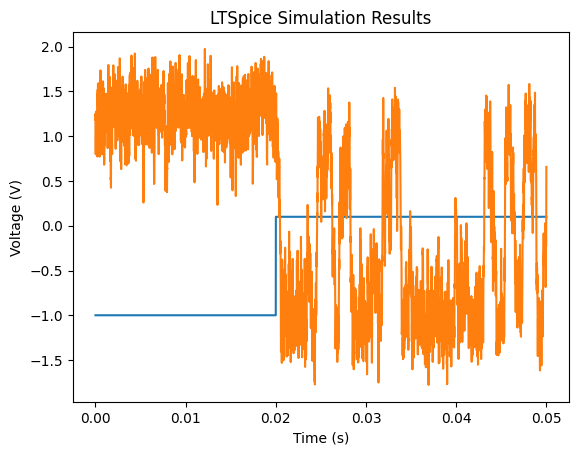

In [63]:
# Plot the results
plt.plot(time[time>0], Vin[time>0])
plt.plot(time[time>0], Vout[time>0])
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.title('LTSpice Simulation Results')
plt.show()

In [64]:
# logic to find kramer's time

# time index of pulse from 30 ms to

Vout1 = Vout[time>(20e-3)]
time1 = time[time>(20e-3)]
indx = 0
for v in Vout1:
    indx = indx + 1
    if v < -0.95:
        time_val = time1[indx]
        break

print(time_val - 20e-3)

0.0005692648887634273


## Code to automate the Tkramers process

* pulse width fixed as 30 ms
* noise variance - 0.5, 1, 1.5, 2, 2.5, 3 
* bias = 0.1, 0.2, 0.3
* each variance values are tested 100 times, and avaraged
* one iteration iteration takes around 5s

In [67]:
noise_var = [0.5, 0.75, 1, 1.25, 1.5, 1.75, 2, 2.25, 2.5]
ktime = [] #for one bias value

#kramers_pulse is generated
kramers_pulse = gen_TRAG_pulse(duration = 50e-3, sampling_rate = 10e6,Vreset = -1,treset = 20e-3,Vpulse = 0.1,tpulse = 30e-3)
with open(TRAG_pulse_data_file, 'w') as f:
    for t, v in kramers_pulse:
        f.write(f"{t:.6e} {v:.6e}\n")
print("TRAG_pulse_pwl.txt generated")

for var in noise_var:
    rep = 100
    kt = [] #for each variance value
    while(rep>0):
        rep = rep-1
        noisedata  = gen_noise(duration = 50e-3, sampling_rate = 10e6, noise_bw = 80e3, mean = 0.0, std_dev = np.sqrt(var))
        with open(noise_data_file, 'w') as f:
            for t, v in noisedata:
                f.write(f"{t:.6e} {v:.6e}\n")
        
        #running simulation
        RunLTsimulation(netlist_file)
        
        # Load the LTSpice data
        lt = ltspice.Ltspice("c:\\Drive\\FE_SR\\kramers_time_spice\\Double_well_ckt_netlist.raw")
        lt.parse()

        # Extract data
        time = lt.get_data('time')
        Vin= lt.get_data('V(Mod_sig)')
        Vout = lt.get_data('V(Vout)')

        Vout1 = Vout[time>(20e-3)]
        time1 = time[time>(20e-3)]
        indx = 0
        for v in Vout1:
            indx = indx + 1
            if v < -0.95:
                time_val = time1[indx]
                break
        kt.append(time_val-20e-3)
    print(kt)
    ktime.append(kt)

TRAG_pulse_pwl.txt generated
[0.02786652699112892, 0.02786652699112892, 0.02786652699112892, 0.02151247814297676, 0.02151247814297676, 0.02151247814297676, 0.013424999564886093, 0.013424999564886093, 0.013424999564886093, 0.013424999564886093, 0.013424999564886093, 0.022467914521694183, 0.022467914521694183, 0.022467914521694183, 0.018525011390447616, 0.018525011390447616, 0.02007064178586006, 0.02007064178586006, 0.02007064178586006, 0.02007064178586006, 0.02007064178586006, 0.02007064178586006, 0.02007064178586006, 0.02007064178586006, 0.02007064178586006, 0.02007064178586006, 0.02007064178586006, 0.02007064178586006, 0.02007064178586006, 0.02007064178586006, 0.02007064178586006, 0.002837450727820396, 0.002837450727820396, 0.002837450727820396, 0.002837450727820396, 0.002837450727820396, 0.002837450727820396, 0.002837450727820396, 0.019561044424772262, 0.019561044424772262, 0.005857307016849517, 0.00988746017217636, 0.015106383264064788, 0.015106383264064788, 0.024612519443035125, 0.

[0.015982821341603993, 0.010338717885315415, 0.007156649008393285, 0.004558140225708483, 0.0038083543442189675, 0.002381127029657364, 0.0021855853870511054, 0.001840291954576969, 0.0016528795659542083]


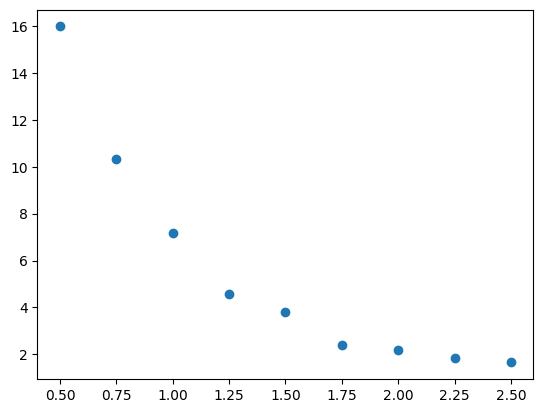

In [69]:
ktime = np.array(ktime)
kramers_time = [i.sum()/100 for i in ktime]
print(kramers_time)
plt.scatter(noise_var,np.array(kramers_time)*1e3)